In [1]:
import requests
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import brier_score_loss, log_loss


# Set Seaborn style
sns.set_style("whitegrid")

def fetch_zip_file(url):
    """
    Fetches the zip file from a URL and returns it as an in-memory ZipFile object.
    """
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful
    return zipfile.ZipFile(io.BytesIO(response.content))


In [2]:
seasons = [f"{i}{i+1}" for i in range(14, 25)]
all_dfs = []
# Loop through all seasons
for season in seasons:
    try:
        print(f"Fetching data for season: {season}")
        
        # URL of the zip file
        url = f"https://www.football-data.co.uk/mmz4281/{season}/data.zip"

        # Fetch the zip file
        zip_file = fetch_zip_file(url)
        if zip_file:
            # Extract CSV data with error handling
            dfs = []
            for file_name in zip_file.namelist():
                if file_name.endswith('.csv'):
                    try:
                        df = pd.read_csv(zip_file.open(file_name), encoding='utf-8')
                        dfs.append(df)
                    except Exception as e:
                        print(f"Skipping file {file_name} due to error: {e}")
                        continue  # Skip this file and continue with others

            # Combine all DataFrames for the current season
            if dfs:
                season_df = pd.concat(dfs, ignore_index=True)
                season_df.columns = season_df.columns.str.lower()
                season_df = season_df[~season_df['div'].isna()].reset_index(drop=True)
                season_df['season'] = season  # Add season column
                all_dfs.append(season_df)  # Store for later concatenation

    except Exception as e:
        print(f"Skipping season {season} due to error: {e}")
        continue  # Move to the next season
# Combine all DataFrames
combined_df = pd.concat(all_dfs, ignore_index=True)
combined_df.columns = combined_df.columns.str.lower()
combined_df = combined_df[~combined_df['div'].isna()].reset_index(drop=True)

print("Combined DataFrame:")
print(combined_df.head())

Fetching data for season: 1415
Fetching data for season: 1516
Fetching data for season: 1617
Skipping file EC.csv due to error: 'utf-8' codec can't decode byte 0xf6 in position 9847: invalid start byte
Fetching data for season: 1718
Fetching data for season: 1819
Skipping file EC.csv due to error: 'utf-8' codec can't decode byte 0xa0 in position 90542: invalid start byte
Skipping file I2.csv due to error: 'utf-8' codec can't decode byte 0xa0 in position 63072: invalid start byte
Skipping file SC0.csv due to error: 'utf-8' codec can't decode byte 0xa0 in position 42709: invalid start byte
Fetching data for season: 1920
Fetching data for season: 2021
Skipping file EC.csv due to error: 'utf-8' codec can't decode byte 0x92 in position 4615: invalid start byte
Fetching data for season: 2122
Skipping file EC.csv due to error: 'utf-8' codec can't decode byte 0x92 in position 1936: invalid start byte
Fetching data for season: 2223
Fetching data for season: 2324
Fetching data for season: 2425
C

## Total Goal > 2.5

In [3]:
tier_1_league = ['D1', 'E0', 'F1', 'I1', 'SP1']
tier_2_league = ['B1', 'D2', 'E1', 'F2', 'I2', 'N1', 'P1', 'SC0', 'SP2']

selected_columns = [
    'season', 'div', 'date',
    'hometeam', 'awayteam', 
    'fthg', 'ftag',
    "b365c>2.5", "b365c<2.5",
    "pc>2.5", "pc<2.5",
    "bfec>2.5", "bfec<2.5",
    "b365>2.5", "b365<2.5", 
    "p>2.5", "p<2.5",
    "bfe>2.5", "bfe<2.5"
]

total_goals = combined_df[selected_columns].reset_index(drop=True)

total_goals['fttg'] = total_goals['fthg'] + total_goals['ftag']
total_goals['ftbig'] = total_goals['fttg'] > 2
total_goals['ftsmall'] = total_goals['fttg'] < 3

new_column_names = {col: col.replace(">2.5", "big").replace("<2.5", "small") for col in total_goals.columns}
total_goals.rename(columns=new_column_names, inplace=True)

total_goals['best_big'] = total_goals[['b365big', 'pbig', 'bfebig']].max(axis=1)
total_goals['best_small'] = total_goals[['b365small', 'psmall', 'bfesmall']].max(axis=1)

total_goals['best_bigc'] = total_goals[['b365cbig', 'pcbig', 'bfecbig']].max(axis=1)
total_goals['best_smallc'] = total_goals[['b365csmall', 'pcsmall', 'bfecsmall']].max(axis=1)

total_goals['best_overround'] = 1/total_goals['best_big'] + 1/total_goals['best_small']
total_goals['best_overroundc'] = 1/total_goals['best_bigc'] + 1/total_goals['best_smallc']

total_goals['best_margin'] = 1 - (1/total_goals['best_overround'])
total_goals['best_marginc'] = 1 - (1/total_goals['best_overroundc'])

total_goals['best_big_imp'] = 1/total_goals['best_big'] / total_goals['best_overround']
total_goals['best_small_imp'] = 1/total_goals['best_small'] / total_goals['best_overround']

total_goals['best_bigc_imp'] = 1/total_goals['best_bigc'] / total_goals['best_overroundc']
total_goals['best_smallc_imp'] = 1/total_goals['best_smallc'] / total_goals['best_overroundc']

total_goals = total_goals.dropna(subset = 'best_big').reset_index(drop=True)
total_goals['best_margin_change'] = total_goals['best_marginc'] - total_goals['best_margin'] 

mean_stat = total_goals.groupby(['season', 'div'])[
['best_margin', 'best_marginc', 'best_margin_change',
 'best_big_imp','best_bigc_imp', 'ftbig',
 'best_small_imp', 'best_smallc_imp', 'ftsmall']
].mean().reset_index()

# Compute the metrics
prob_quality = total_goals.groupby(['season', 'div']).apply(lambda x: pd.Series({
    'brier_score_best_big_imp': brier_score_loss(x.ftbig, x.best_big_imp),
    'brier_score_best_bigc_imp': brier_score_loss(x.ftbig, x.best_bigc_imp),
    'log_loss_best_big_imp': log_loss(x.ftbig, x.best_big_imp),
    'log_loss_best_bigc_imp': log_loss(x.ftbig, x.best_bigc_imp),
    'brier_score_best_small_imp': brier_score_loss(x.ftsmall, x.best_small_imp),
    'brier_score_best_smallc_imp': brier_score_loss(x.ftsmall, x.best_smallc_imp),
    'log_loss_best_small_imp': log_loss(x.ftsmall, x.best_small_imp),
    'log_loss_best_smallc_imp': log_loss(x.ftsmall, x.best_smallc_imp)
    
})).reset_index()

prob_quality['brier_score_big_spread'] = prob_quality['brier_score_best_bigc_imp'] - prob_quality['brier_score_best_big_imp'] 
prob_quality['brier_score_small_spread'] = prob_quality['brier_score_best_smallc_imp'] - prob_quality['brier_score_best_small_imp'] 

prob_quality['log_loss_big_spread'] = prob_quality['log_loss_best_bigc_imp'] - prob_quality['log_loss_best_big_imp'] 
prob_quality['log_loss_small_spread'] = prob_quality['log_loss_best_smallc_imp'] - prob_quality['log_loss_best_small_imp'] 

In [4]:
def create_line_plot(data, x, y, hue, title, xlabel, ylabel, figsize=(10, 6)):
    """
    Creates a seaborn line plot with the specified parameters.

    Parameters:
    - data (DataFrame): The data to plot.
    - x (str): Column name for the x-axis.
    - y (str): Column name for the y-axis.
    - hue (str): Column name for the hue (legend).
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - figsize (tuple): Size of the figure.
    """
    plt.figure(figsize=figsize)
    
    sns.lineplot(
        data=data,
        x=x,
        y=y,
        hue=hue,
        marker='o',
        linewidth=2,
        markersize=8
    )
    
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(title=hue.capitalize())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Define your tiers
tiers = {
    'Tier 1': tier_1_league,
    'Tier 2': tier_2_league
}

# Define the different metrics you want to plot, specifying the DataFrame for each
plot_configs = [
    {
        'data_key': 'best_margin',
        'y_label': 'Margin',
        'title_suffix': 'Best Initial Margin by Season and Division',
        'data_frame': 'mean_stat',
    },
    {
        'data_key': 'best_marginc',
        'y_label': 'Margin',
        'title_suffix': 'Best Closing Margin by Season and Division',
        'data_frame': 'mean_stat',
    },
    {
        'data_key': 'best_margin_change',
        'y_label': 'Best Margin Change',
        'title_suffix': 'Best Margin Change by Season and Division',
        'data_frame': 'mean_stat',
    },
    {
        'data_key': 'ftbig',
        'y_label': 'Prob of Full-time > 2.5',
        'title_suffix': 'Prob of Full-time > 2.5 by Season and Division',
        'data_frame': 'mean_stat',
    },
    {
        'data_key': 'best_big_imp',
        'y_label': 'Implied Prob Initial of Full-time > 2.5',
        'title_suffix': 'Implied Prob Initial of Full-time > 2.5 by Season and Division',
        'data_frame': 'mean_stat',
    },
    {
        'data_key': 'best_bigc_imp',
        'y_label': 'Implied Prob Closing of Full-time > 2.5',
        'title_suffix': 'Implied Prob Closing of Full-time > 2.5 by Season and Division',
        'data_frame': 'mean_stat',
    },
    {
        'data_key': 'brier_score_best_big_imp',
        'y_label': 'Brier Score',
        'title_suffix': 'Brier Score Implied Prob Initial of Full-time > 2.5 by Season and Division',
        'data_frame': 'prob_quality',
    },
    {
        'data_key': 'brier_score_best_bigc_imp',
        'y_label': 'Brier Score',
        'title_suffix': 'Brier Score Implied Prob Closing of Full-time > 2.5 by Season and Division',
        'data_frame': 'prob_quality',
    },
    {
        'data_key': 'log_loss_best_big_imp',
        'y_label': 'Log Loss',
        'title_suffix': 'Log Loss Implied Prob Initial of Full-time > 2.5 by Season and Division',
        'data_frame': 'prob_quality',
    },
    {
        'data_key': 'log_loss_best_bigc_imp',
        'y_label': 'Log Loss',
        'title_suffix': 'Log Loss Implied Prob Closing of Full-time > 2.5 by Season and Division',
        'data_frame': 'prob_quality',
    },
    {
        'data_key': 'brier_score_big_spread',
        'y_label': 'Brier Score Change',
        'title_suffix': 'Brier Score Change of Full-time > 2.5 by Season and Division',
        'data_frame': 'prob_quality',
    },
    {
        'data_key': 'log_loss_big_spread',
        'y_label': 'Log Loss Change',
        'title_suffix': 'Log Loss Change of Full-time > 2.5 by Season and Division',
        'data_frame': 'prob_quality',
    },
]

# Define a mapping from DataFrame names to actual DataFrames
df_mapping = {
    'mean_stat': mean_stat,
    'prob_quality': prob_quality
}

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


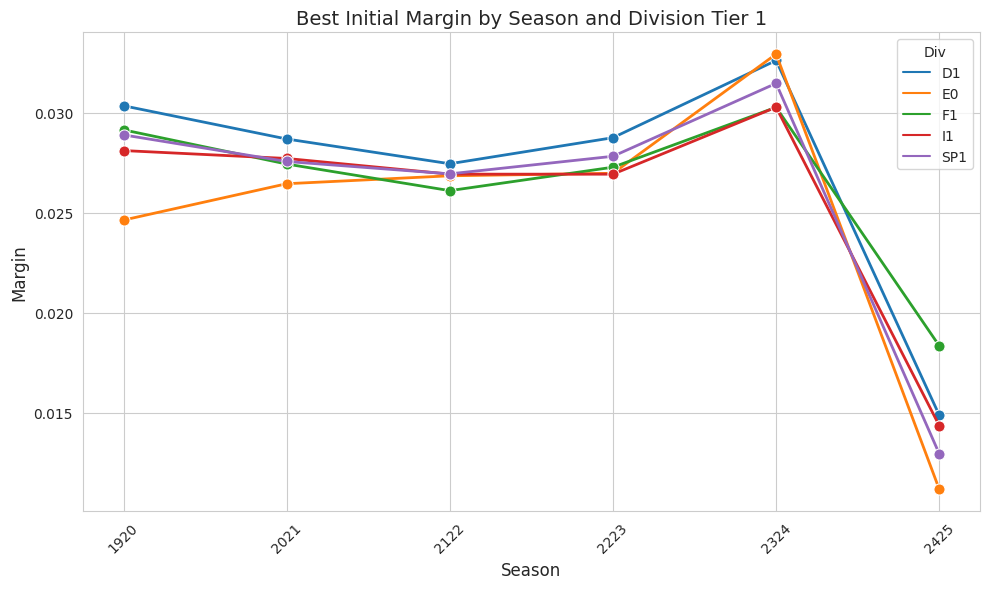

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


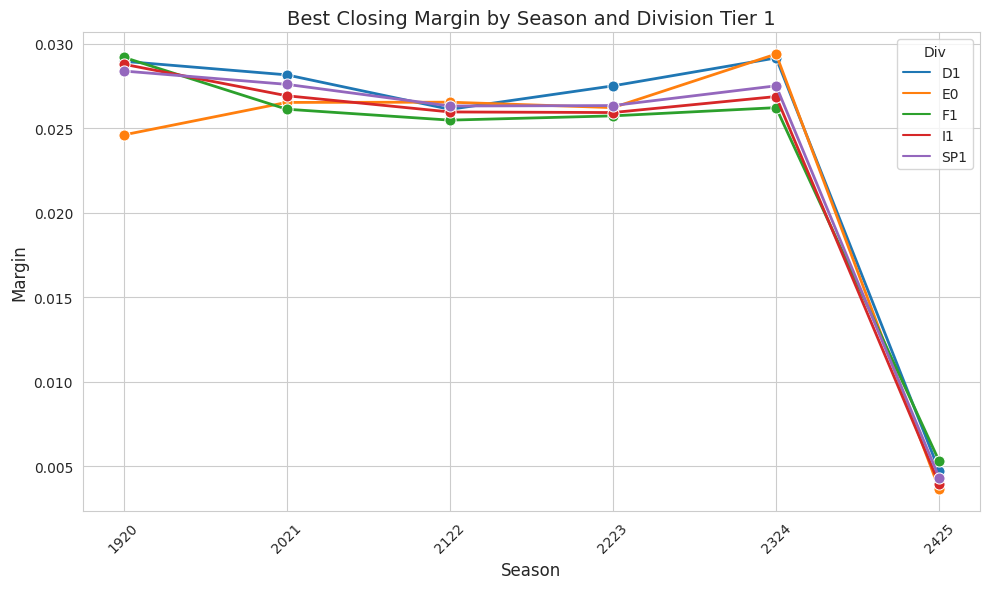

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


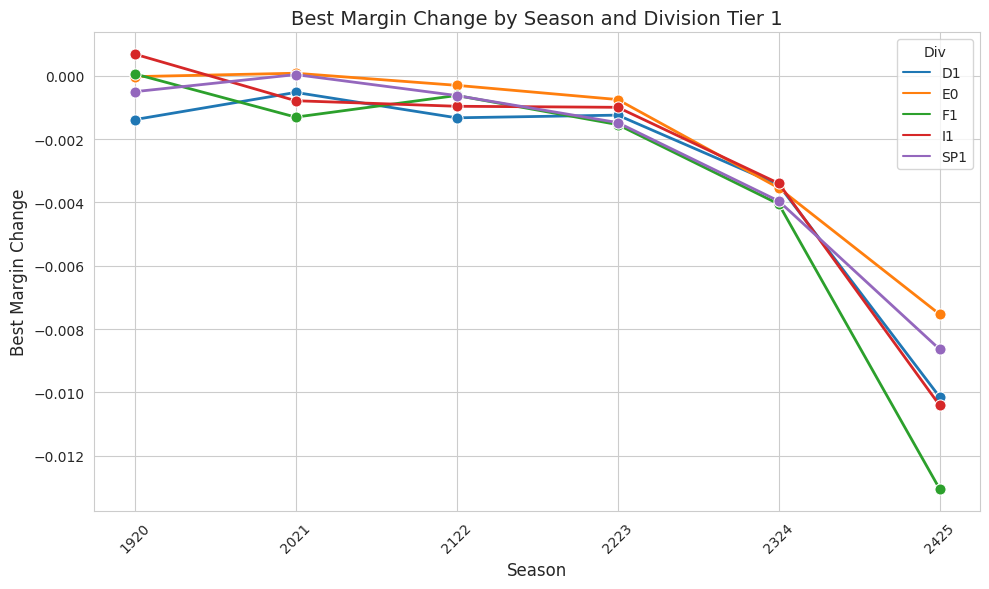

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


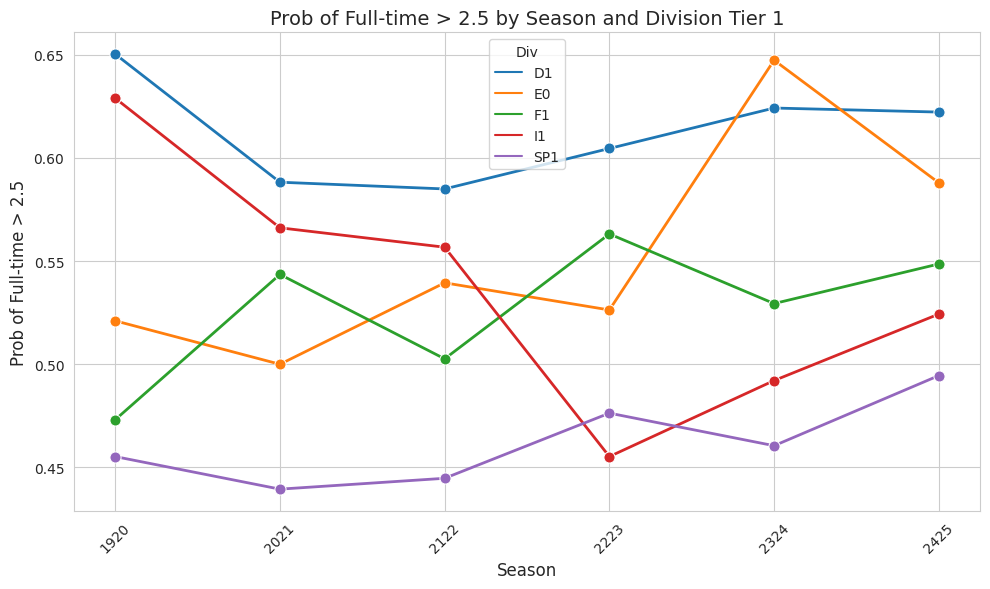

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


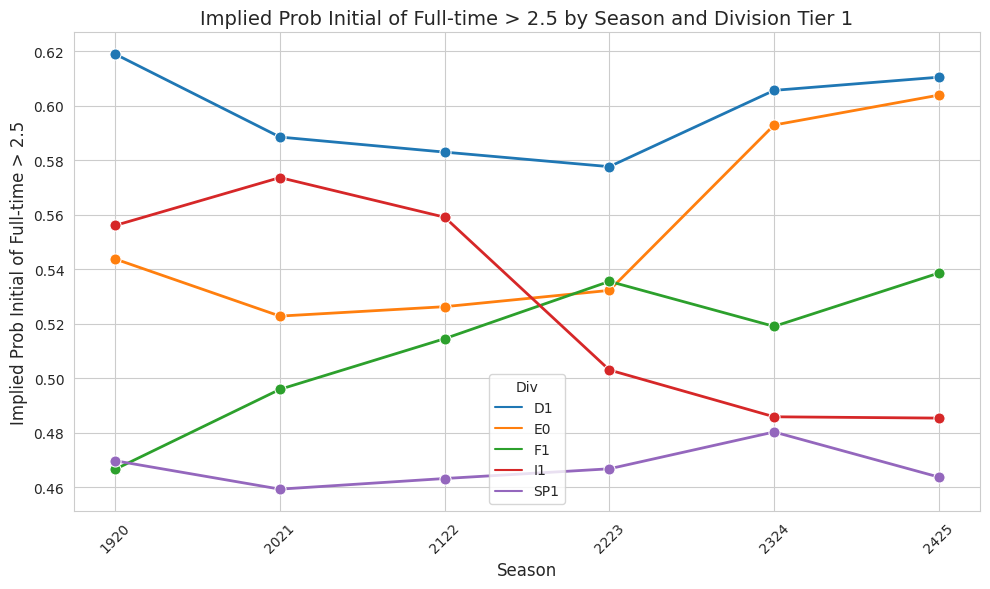

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


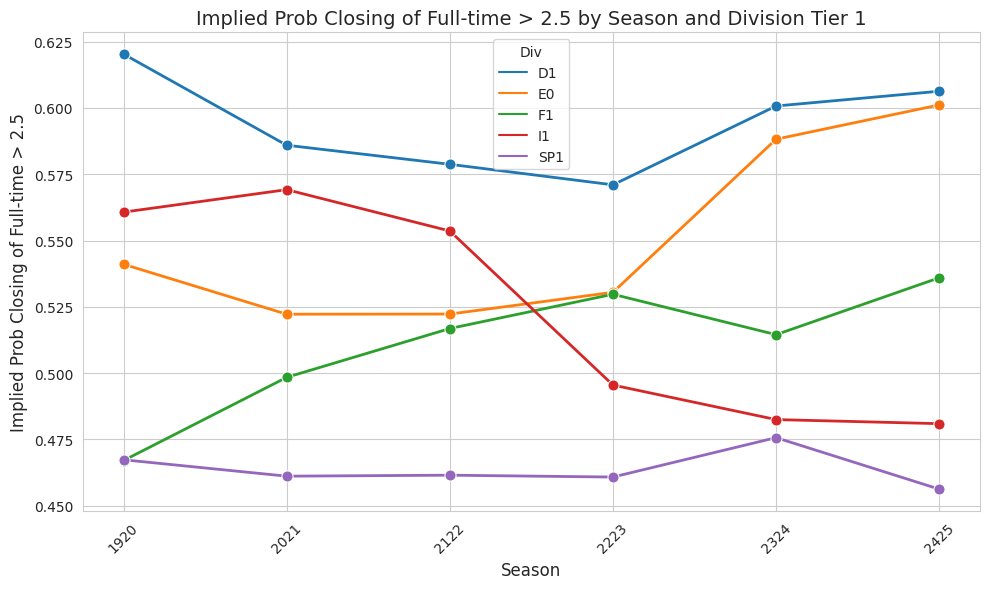

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


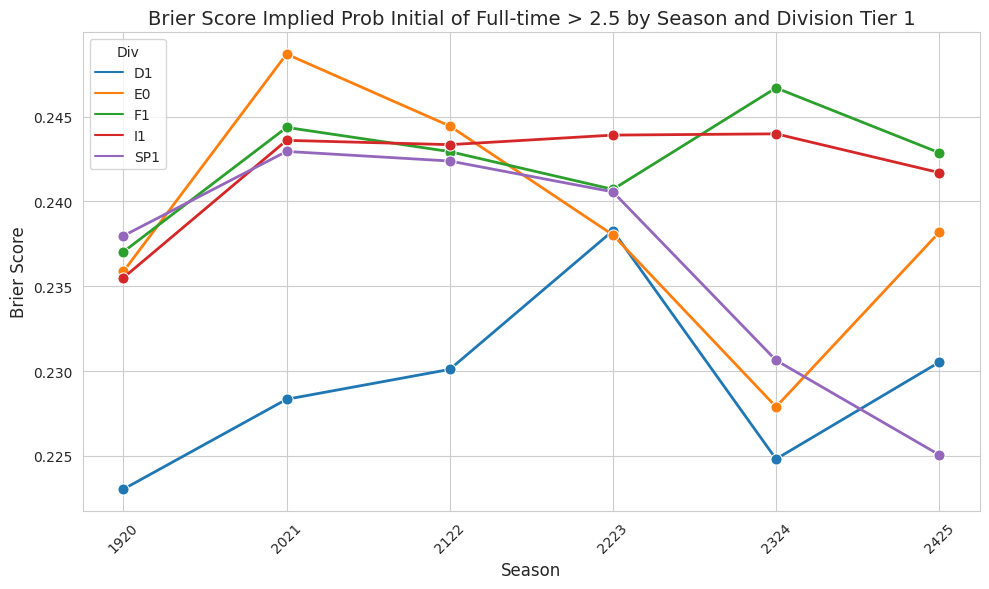

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


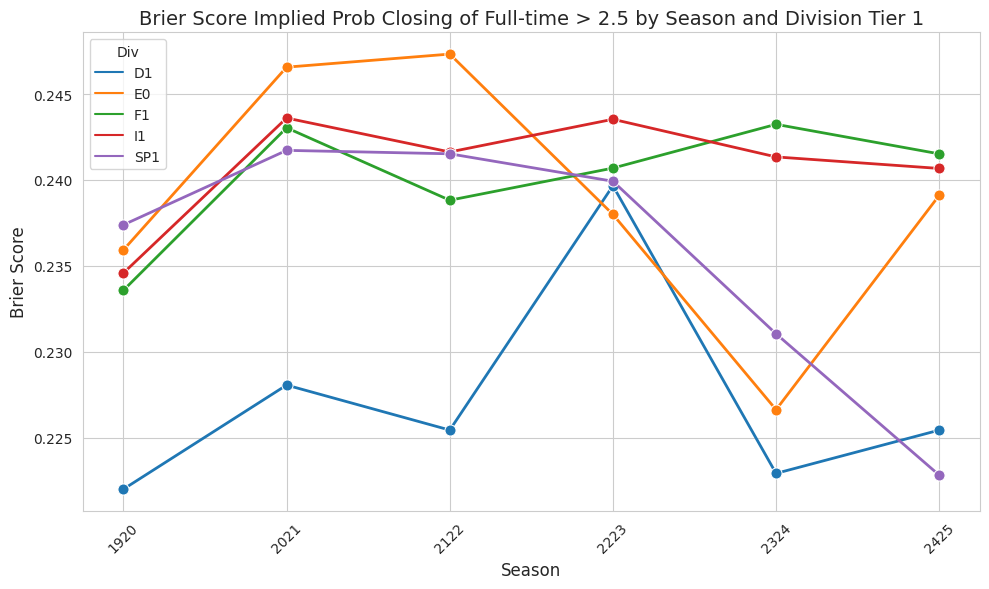

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


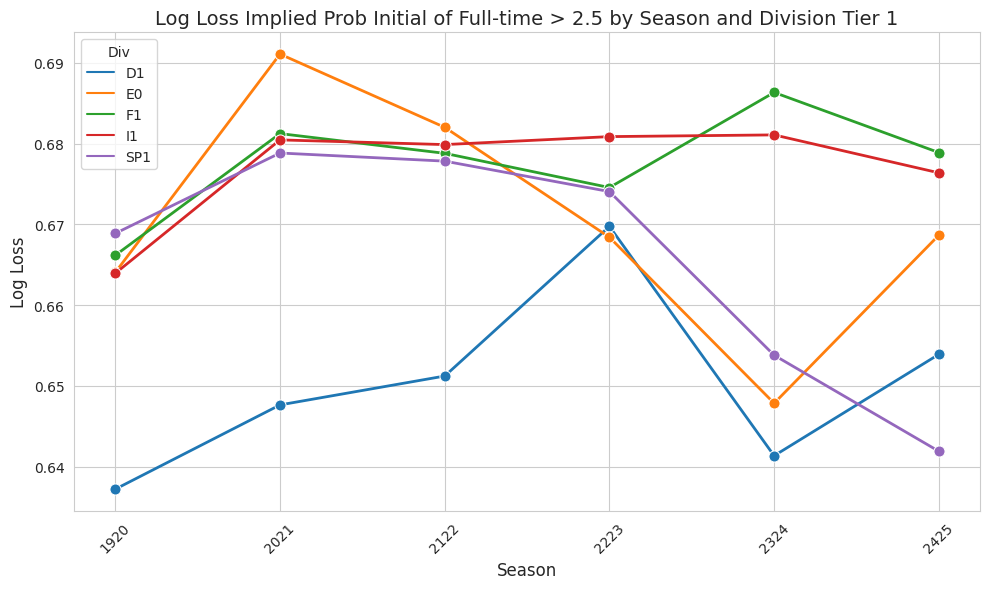

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


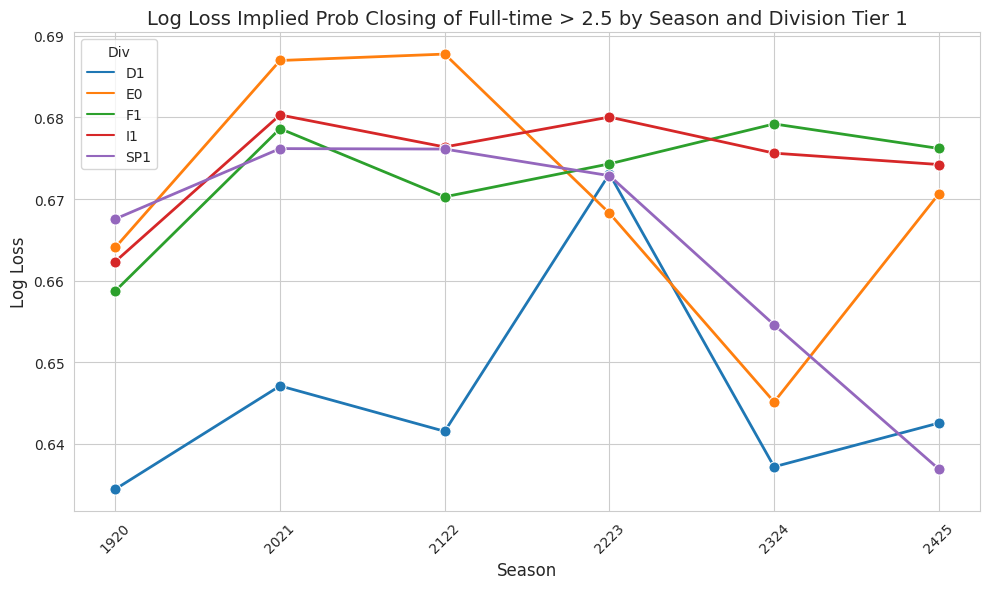

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


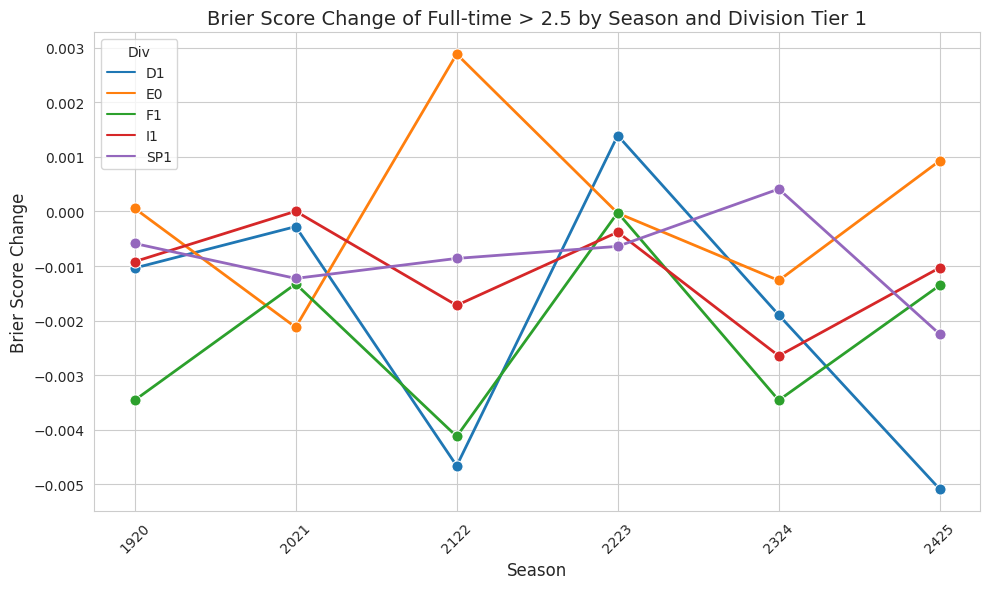

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


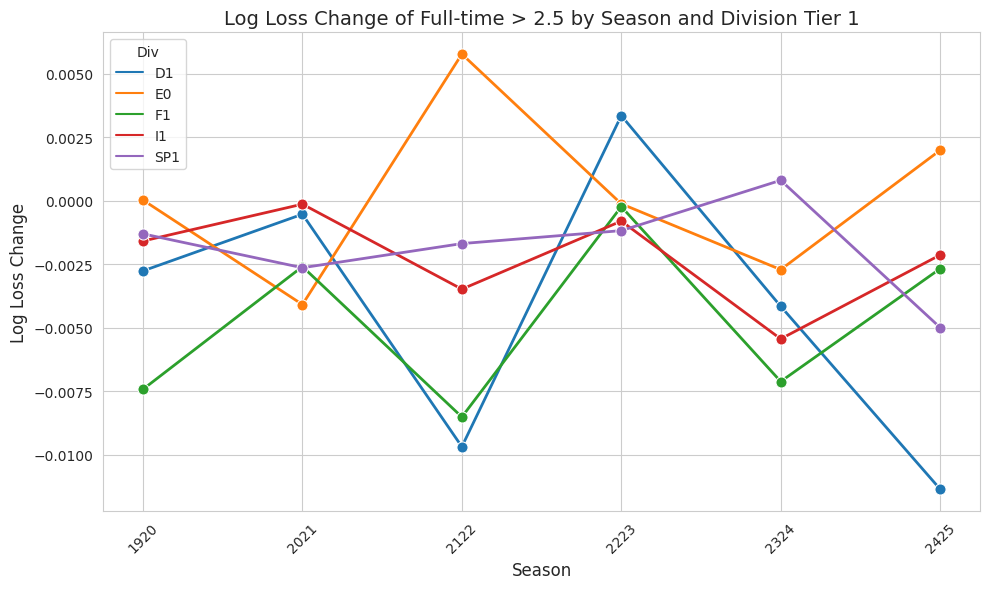

In [5]:
# Iterate over each tier
# for tier_name, league_list in tiers.items():
tier_name = 'Tier 1'
league_list = tiers[tier_name]

# Iterate over each plot configuration
for config in plot_configs:
    # Select the appropriate DataFrame based on the configuration
    df_to_plot = df_mapping.get(config['data_frame'])
    
    if df_to_plot is None:
        print(f"DataFrame '{config['data_frame']}' not found. Skipping plot for '{config['data_key']}'.")
        continue  # Skip to the next iteration if DataFrame is not found
    
    # Subset the data for the current tier
    subset_data = df_to_plot[df_to_plot['div'].isin(league_list)]
    
    # Define the plot title
    title = f"{config['title_suffix']} {tier_name}"
    
    # Create the plot
    create_line_plot(
        data=subset_data,
        x='season',
        y=config['data_key'],
        hue='div',
        title=title,
        xlabel='Season',
        ylabel=config['y_label']
    )


**Preliminary Conclusions**

1. **Goal Scoring Trends**
    - Except for La Liga, more than half of the matches in major European leagues result in two or more goals.
    - In the Bundesliga, over 60% of matches end with two or more goals.

2. **Increase in Goal Scoring Probability**
    - The probability of scoring two or more goals has moderately increased across major European leagues.

3. **Odds Margin Analysis**
    - The difference between the best initial odds margin and the closing odds margin remained steady until the 2022-2023 season. Since the 2023-2024 season, this difference has decreased dramatically.
        - Interestingly, the initial margin increased in the 2023-2024 season but then decreased significantly in the 2024-2025 season.
        - If the margin charged by bookmakers is considered a measure of uncertainty, why did uncertainty suddenly resolve in the 2024-2025 season?

4. **Consistency of Implied Probabilities**
    - The implied probabilities of scoring two or more goals are generally consistent with the actual probabilities observed in the respective league.

5. **Comparison of Initial and Closing Odds**
    - The implied probabilities derived from initial odds and closing odds are similar. However, closing odds provide marginally better probability predictions than initial odds, as evidenced by improved Brier Scores and Log-Loss scores.
    - The implied probabilities for the Seria A and Ligue 1 seem to have a lower predictive power than those for the other three leagues.